In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline


/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# TESTING FOR REDUCING FEATURES - WILL SEE IF RIGHT

## Exploratory Data Analysis and Building a model for relationship between greenhouse gas emissions from a car and that car's features

We've collected the data, cleaned it up -- now let's build a model!

### Step 1: Prepare dataframe for developing linear regression model
*Edit and add features as needed for desired model*

-

Open the `all_cars_eda` pickled dataframe with all cars data

In [5]:
with open('pickles/all_cars_eda.pickle','rb') as read_file:
    all_cars_eda = pickle.load(read_file)

-

Create binned categories for `years` based on the year timeframes that the EPA developed national regulations for cars' greenhouse gas emissions:
- 1984 - 2011: 'pre' strict regulations around emissions
- 2012 - 2020: implementation of regulations around emissions
- 2021: period where regulations were scaled back to be less strict

In [6]:
all_cars_eda['year_range'] = ['year_pre_regulations' if
                              year in [1984, 1985, 1986, 
                                       1987, 1988, 1989, 
                                       1990, 1991, 1992, 
                                       1993, 1994, 1995, 
                                       1996, 1997, 1998, 
                                       1999, 2000, 2001,
                                       2002, 2003, 2004,
                                       2005, 2006, 2007,
                                       2008, 2009, 2010,
                                       2011]
                              
                              else 'year_regulations' if 
                              year in [2012,2013,2014,2015,
                                       2016,2017,2018,2019,
                                       2020]
                              
                              else 'year_post_regulations' if 
                              year in [2021]
                              
                              else np.nan for year in all_cars_eda['year']]

Note that we now only have 36 samples in the `year_post_regulations` so will not be enough to draw reliable conclusions from.  But will keep in for now to see any indictation of direction greenhouse gases will take 2021 and beyond >>

In [7]:
all_cars_eda.year_range.value_counts()

year_pre_regulations     3553
year_regulations         1671
year_post_regulations      36
Name: year_range, dtype: int64

-

**REMOVING FEATURES**

**Removing miles-per-gallon - `mpg`.**  By removing we'll allow opportunity to examine any relationships between the other features of the car and the greenhouse gas emissions, otherwise miles-per-gallon would be too dominant of feature and also isn't really telling us more deeply what causes greenhouse gas emissions from the mechanics of how the car was built

**Removing `make`, `model`, & `trans_speed`.**  Can say with confidence these are not signiciantly relevant to the greenhouse gas emissions of the car and would not be worth create dummies for the non-numberic categories.

**Removing `year`.**  Will just use the dummy columns created for years.

In [8]:
del all_cars_eda['mpg']
del all_cars_eda['make']
del all_cars_eda['model']
del all_cars_eda['trans_speed']
del all_cars_eda['year']

Verify everything looks okay >>

In [9]:
all_cars_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5264
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   capacity_liters  5260 non-null   float64
 1   cylinders        5260 non-null   int32  
 2   transmission     5260 non-null   object 
 3   fuel_type        5260 non-null   object 
 4   gg_emissions     5260 non-null   float64
 5   year_range       5260 non-null   object 
dtypes: float64(2), int32(1), object(3)
memory usage: 267.1+ KB


-

Create the dummies for the features that are objects >>

In [10]:
all_cars_eda = pd.get_dummies(all_cars_eda)

In [11]:
all_cars_eda.columns

Index(['capacity_liters', 'cylinders', 'gg_emissions',
       'transmission_Automatic', 'transmission_Manual', 'fuel_type_Diesel',
       'fuel_type_Premium Gasoline', 'fuel_type_Regular Gasoline',
       'year_range_year_post_regulations', 'year_range_year_pre_regulations',
       'year_range_year_regulations'],
      dtype='object')

In [12]:
all_cars_eda.rename(columns = {'fuel_type_Premium Gasoline': 'fuel_premium',
                               'fuel_type_Regular Gasoline': 'fuel_regular',
                               'year_range_year_post_regulations': 'year_post_regulations',
                               'year_range_year_pre_regulations': 'year_pre_regulations',
                               'year_range_year_regulations': 'year_regulations'
                              },
                    inplace = True)

### Step 2: Exploratory Data Analysis

#### CORRELATION

Examine the correlations of all the values>>

In [107]:
all_cars_eda.corr()

,capacity_liters,cylinders,gg_emissions,transmission_Automatic,transmission_Manual,fuel_type_Diesel,fuel_premium,fuel_regular,year_post_regulations,year_pre_regulations,year_regulations
capacity_liters,1.000000,0.906330,0.773934,0.264746,-0.264746,0.126013,0.135443,-0.199060,-0.044218,0.149540,-0.142552
cylinders,0.906330,1.000000,0.740521,0.309784,-0.309784,0.064916,0.253522,-0.276253,-0.032053,0.105251,-0.100168
gg_emissions,0.773934,0.740521,1.000000,0.169507,-0.169507,-0.010432,0.117899,-0.105576,-0.061894,0.343847,-0.334823
transmission_Automatic,0.264746,0.309784,0.169507,1.000000,-1.000000,-0.058951,0.196403,-0.152445,0.059522,-0.361508,0.353004
transmission_Manual,-0.264746,-0.309784,-0.169507,-1.000000,1.000000,0.058951,-0.196403,0.152445,-0.059522,0.361508,-0.353004
fuel_type_Diesel,0.126013,0.064916,-0.010432,-0.058951,0.058951,1.000000,-0.198311,-0.376113,-0.024832,0.046135,-0.041997
fuel_premium,0.135443,0.253522,0.117899,0.196403,-0.196403,-0.198311,1.000000,-0.833584,0.020070,-0.262578,0.260503
fuel_regular,-0.199060,-0.276253,-0.105576,-0.152445,0.152445,-0.376113,-0.833584,1.000000,-0.004978,0.222227,-0.222597
year_post_regulations,-0.044218,-0.032053,-0.061894,0.059522,-0.059522,-0.024832,0.020070,-0.004978,1.000000,-0.119765,-0.056644
year_pre_regulations,0.149540,0.105251,0.343847,-0.361508,0.361508,0.046135,-0.262578,0.222227,-0.119765,1.000000,-0.984424


-

Now narrow in on just the greenhouse gas emissions column (the 'y') to examine the value of greatest interest more easily >>

In [108]:
(all_cars_eda.corr()).iloc[:,2]

capacity_liters           0.773934
cylinders                 0.740521
gg_emissions              1.000000
transmission_Automatic    0.169507
transmission_Manual      -0.169507
fuel_type_Diesel         -0.010432
fuel_premium              0.117899
fuel_regular             -0.105576
year_post_regulations    -0.061894
year_pre_regulations      0.343847
year_regulations         -0.334823
Name: gg_emissions, dtype: float64

-

Now create a heatmap to help look at the relationships of the values >>

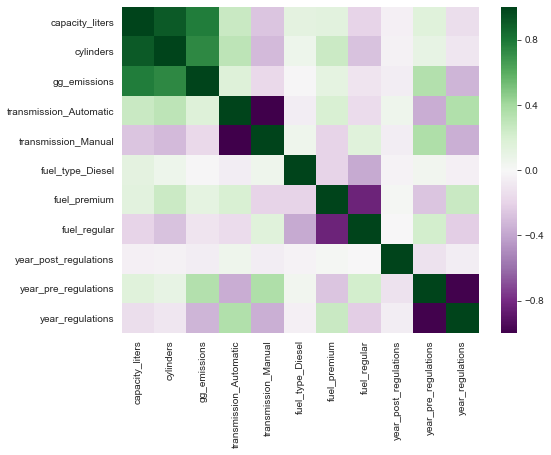

In [109]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(all_cars_eda.corr(), cmap="PRGn")
ax.set_ylim(11.0, 0);

And now a Greenhouse Gas Emissions correlation matrix

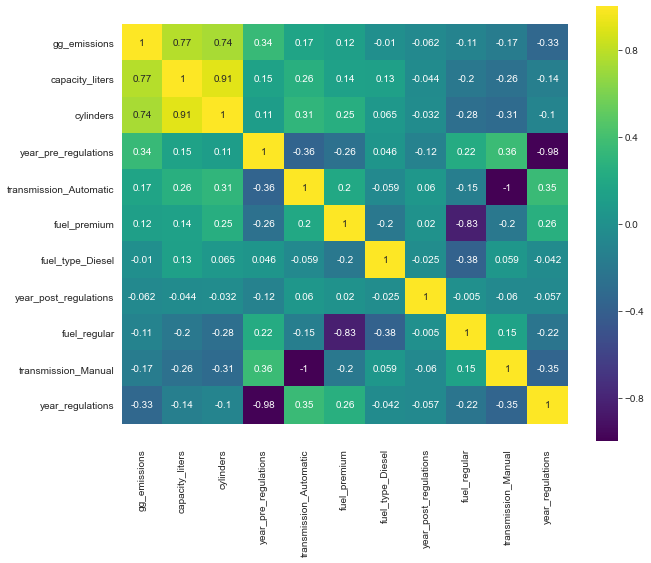

In [110]:
k = 11
cols = all_cars_eda.corr().nlargest(k, 'gg_emissions')['gg_emissions'].index
cm = all_cars_eda[cols].corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, cmap = 'viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

Create a pair plot for a deeper look at relationship between all features and variable >>

In [26]:
sns.pairplot(all_cars_eda, height=11, aspect=1.5);

#### OUTLIERS EXAMINATION

For our non-dummied features, we'll look at their outliers (dummies can be ignored) >>

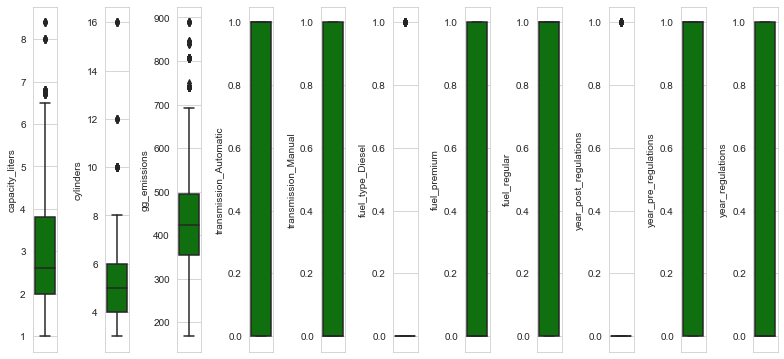

In [112]:
l = all_cars_eda.columns.values
number_of_columns=11
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(all_cars_eda[l[i]],color='green',orient='v')
    plt.tight_layout()

#### CHECK DISTRIBUTION SKEWNESS

Again for our non-dummied features, we'll look at their skewness (dummies can be ignored) >>

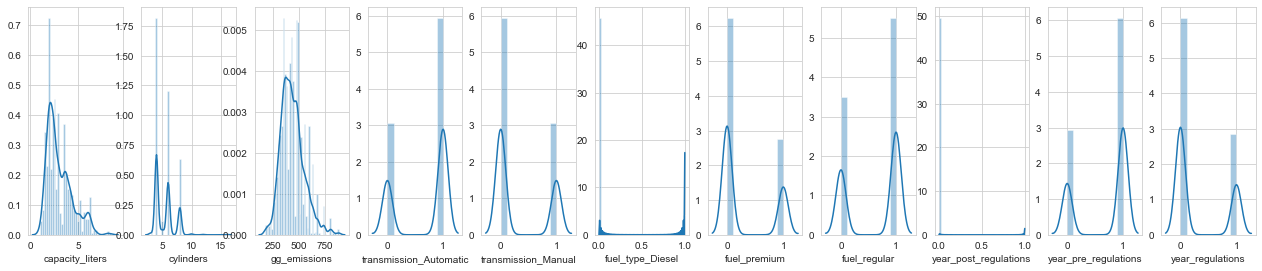

In [113]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(all_cars_eda[l[i]],kde=True)

### STEP 3: BUILD THE MODEL - REDUCING TO JUST USE  `year_regulations` for year

In [19]:
# Define the model for greenhouse gas emissions of cars
cars_model = smf.ols('''gg_emissions ~ capacity_liters + cylinders 
              + transmission_Automatic + transmission_Manual
              + fuel_regular + year_regulations''',
                     data=all_cars_eda)

# Fit the model
cars_fit = cars_model.fit()

# Print summary statistics of the model's performance
cars_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     2080.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:35:19   Log-Likelihood:                -29393.
No. Observations:                5260   AIC:                         5.880e+04
Df Residuals:                    5254   BIC:                         5.884e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                152.4290      2.953     51.623      0.000     146.641     158.218
capacity_liters           42.4880      1.619     26.245      0.000      39.314      45.662
cylinders                 16.9866      1.351     12.572      0.000      14.338      19.635
transmission_Automatic    82.2612      2.052     40.083      0.000      78.238      86.284
transmission_Manual       70.1679      1.581     44.374      0.000      67.068      73.268
fuel_regular               3.2847      1.985      1.655      0.098      -0.607       7.176
year_regulations         -60.7186      2.188    -27.757      0.000     -65.007     -56.430
==============================================================================
Omnibus:                      349.557   Durbin-Watson:                   0.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              805.601
Skew:                           0.417   Prob(JB):                    1.16e-175
Kurtosis:                       4.726   Cond. No.                     2.30e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.38e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

-

#### PLOT THE RESIDUALS VS FITTED VALUES

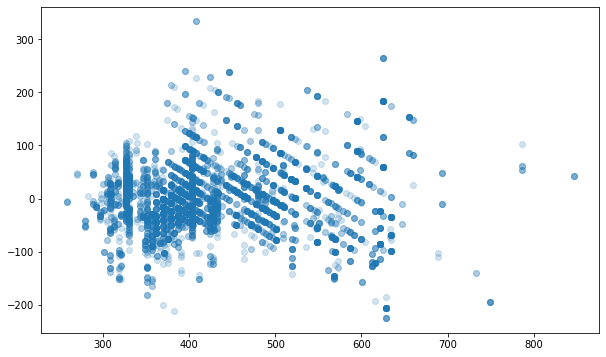

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(cars_fit.predict(), cars_fit.resid, alpha=0.2);

#### USE SKLEARN TO GET MODEL STATS - SHOULD MATCH ABOVE

*Only used as test to verify different method to get values works*

In [24]:
# Create an empty model
cars_lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
X = all_cars_eda.loc[:, ['capacity_liters', 'cylinders', 'transmission_Automatic', 
                         'transmission_Manual','fuel_premium','fuel_regular',
                         'year_pre_regulations','year_regulations'
                        ]]

# Identify the response variable
y = all_cars_eda.loc[:, ['gg_emissions']]

# Fit the model to the full dataset
cars_lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
print(f'R^2: {cars_lr.score(X,y)}')
print('\n')
print(f'Intercept: {cars_lr.intercept_}')
print('\n')
print(f'Coefficients: {cars_lr.coef_}')

R^2: 0.677770017963495


Intercept: [130.57663807]


Coefficients: [[46.69872579 13.19020649  5.83753711 -5.83753711 47.63922274 38.56781404
  71.35320944  6.38419454]]
